In [1]:
from tqdm import tqdm
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [2]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'

In [3]:
# Custom imports
sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

In [4]:
def peek(df):
    print(len(df))
    display(df.iloc[:3])

# 1. Collect Stop Sequences

Stop sequences are collected by:
<ol>
  <li>Collecting unique stop sequences from <code>stop_times.txt</code>
  <li>Collecting all trip IDs matching a sequence, for each sequence
  <li>Assigning attributes (e.g. route ID) to each stop sequence based on the commonly observed attribute value within each sequence's matching trips
</ol>

This approach is necessary due to mislabelled data. Rather than rely on potentially mislabelled trips, this approach groups trips based on their published stop times and locations, and then labels their routes based on majority of matched labels. This approach corrects for trips following a route, but mislabelled as a different route. Correctly determining the route to which a trip belongs enables matching the stop sequence of the trip to a predefined route geometry.

In [5]:
# Extract stops used for each trip.
stop_times_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stop_times.txt')
stop_times_df = stop_times_df[['trip_id', 'stop_id']]
peek(stop_times_df)

934109


,trip_id,stop_id
0,MQ_C1-Weekday-032400_M57_451,400745
1,MQ_C1-Weekday-032400_M57_451,402233
2,MQ_C1-Weekday-032400_M57_451,403986


In [6]:
# Convert to/from a stop sequence.
def serialize_stop_ids(stop_ids):
    return ','.join([str(s) for s in stop_ids])
def deserialize_stops_key(stops_key):
    return [int(s) for s in stops_key.split(',')]

In [7]:
# Create dictionary of trip ID to stop sequence.
trip_id_stop_ids_dict = stop_times_df.groupby('trip_id').apply(
    lambda x: list(x['stop_id'])).to_dict()

# Serialize stop sequences.
trip_id_stops_key_dict = {
    trip_id: serialize_stop_ids(stop_ids)
    for trip_id, stop_ids in trip_id_stop_ids_dict.items()
}

# Map stop sequences to list of matching trips.
stops_key_trip_ids_dict = {}
for trip_id, stops_key in trip_id_stops_key_dict.items():
    if stops_key not in stops_key_trip_ids_dict:
        stops_key_trip_ids_dict[stops_key] = []
    stops_key_trip_ids_dict[stops_key].append(trip_id)

In [8]:
# Extract information for each trip.
trips_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/trips.txt')
trips_df = trips_df.set_index('trip_id')
trip_id_route_id_dict = trips_df['route_id'].to_dict()
peek(trips_df)

29055


,route_id,service_id,trip_headsign,direction_id,shape_id
trip_id,,,,,
MQ_C1-Weekday-032400_M57_451,M57,MQ_C1-Weekday,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570110
MQ_C1-Weekday-034000_M57_451,M57,MQ_C1-Weekday,EAST SIDE YORK-60 ST CROSSTOWN,0,M570111
MQ_C1-Weekday-037300_M57_451,M57,MQ_C1-Weekday,WEST SIDE BROADWAY-72 ST CROSSTOWN,1,M570109


In [9]:
# Create sequences from map of stops and matching trips.
sequences = [
    Sequence(deserialize_stops_key(stops_key), trip_ids, trips_df)
    for stops_key, trip_ids in tqdm(stops_key_trip_ids_dict.items())
]

100%|██████████| 146/146 [00:13<00:00, 10.95it/s]


In [10]:
# Export sequences to JSON.
with open(f'{EXPORTS_DIR}/json/manhattan/sequences.json', 'w') as fp:
    sequence_dicts = [s.to_dict() for s in sequences]
    json.dump(sequence_dicts, fp)

## 2. Assign Stop Locations Along Route Geometry

The locations of stops are provided in `stops.txt`, but must be "snapped" to the closest point along a route geometry for linear referencing and time interpolation. Because stops may be shared by multiple routes, "snapped" stop locations may be different for each route. Therefore, a manifest of stop locations per route is calculated. If the distance between a provided stop location and its route-snapped location exceeds a distance threshold, an error is thrown to flag it as potentially inaccurate.

In [1]:
# Custom imports reloaded to enable re-running changes from this point.
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sys

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'

sys.path.append(LIB_DIR)
from gtfs_sequence import Sequence

# Load exported sequences (to enable re-running without re-calculation).
sequences = []
with open(f'{EXPORTS_DIR}/json/manhattan/sequences.json', 'r') as fp:
    sequence_dicts = json.load(fp)
sequences = [Sequence(load_dict=d) for d in sequence_dicts]

def peek(df):
    print(len(df))
    display(df.iloc[:3])

/home/chriscarey/miniconda3/envs/mlc/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.5 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [2]:
# Load stop locations into DataFrame.
stops_df = pd.read_csv(f'{DATA_DIR}/gtfs/manhattan/stops.txt')
stops_df = stops_df.set_index('stop_id')
stops_df = stops_df[['stop_lat', 'stop_lon']]
peek(stops_df)

1808


,stop_lat,stop_lon
stop_id,,
400001,40.731342,-73.990292
400002,40.732608,-73.989958
400003,40.733936,-73.989720


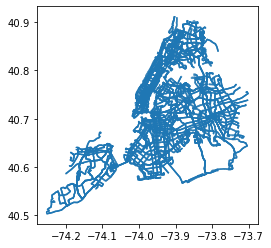

In [3]:
# Load bus route geometries into DataFrame.
routes_gdf = gpd.read_file(f'{DATA_DIR}/shp/bus_routes_nyc_may2020.shp')
routes_gdf = routes_gdf.to_crs(CRS_LATLON)
routes_gdf.plot()
plt.show()

In [4]:
# Assign route geometries and only keep sequences with matching geometries.
print(f'# of sequences before route geometry assignement: {len(sequences)}')
sequences = [s for s in sequences if s.assign_route_geometry(routes_gdf)]
print(f'# of sequences after route geometry assignement: {len(sequences)}')

# of sequences before route geometry assignement: 146
# of sequences after route geometry assignement: 144


In [5]:
for sequence in sequences:
    sequence.assign_stop_coords(stops_df)

In [6]:
# Export sequences to JSON.
with open(f'{EXPORTS_DIR}/json/manhattan/sequences.json', 'w') as fp:
    sequence_dicts = [s.to_dict() for s in sequences]
    json.dump(sequence_dicts, fp)